In [1]:
#Basics
import os
import io
import re
import string
from tqdm import tqdm
import numpy as np
import glob
import pickle

#tf libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

#torch libraries
import torch
from torch import cuda

#Time related libraries
import datetime
from timeit import default_timer as timer

#General libraries
import collections
import math
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

#Dealing with files, data and general stuff
import zipfile
import pandas as pd

#May be used but very unlikely.
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
from numba import jit, cuda #Former way of GPU acceleration in my project.

#Transformers Library. Taken from "Hugging Face".
from transformers import BertConfig, BertModel, BertTokenizer, BertForMaskedLM, BertTokenizerFast, pipeline
from tokenizers import BertWordPieceTokenizer, ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

#Optimizers taken from the "Transformers" Library that I have mentioned above as well.
from transformers import AdamW

In [2]:
tokenizer = BertTokenizer.from_pretrained('G:/VisualStudioCodeG/Resources/Tokenizers/bookcorpus/Run1/BERTbookcorpusTokenizerRun1-vocab.txt', max_length=512)
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

c:\Users\Cthulhu\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:1706: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# To shorten overall runtime, provide convinience and reduce the probability of the kernel crashing; The tokenization of the arrays is done within a different script.
# Please refer to the appropriate tokenization script for tokenizing and saving the list, Once you have done so, You may come back here to load the tokenized data and proceed with the training procedure.

In [4]:
# Unpickle a tokenized array (Load) [Multiple]
#inputs = []
#num = 0

#for i in tqdm(range(num)):
    #with open(f'G:/VisualStudioCodeG/Resources/PickleSaveArrays/inputsArrayRun1/tokenizedText_{i}.txt', "rb") as fp: # rb - Read Binary
        #inputsData = pickle.load(fp)
        #inputs.extend(inputsData)

In [5]:
# Unpickle a tokenized array (Load) [Single]
num = 0 # Index number for the txt file

with open(f'G:/VisualStudioCodeG/Resources/PickleSaveArrays/inputsArrayRun1/tokenizedText_{num}.txt', "rb") as fp: # rb - Read Binary
    inputs = pickle.load(fp)

In [6]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [7]:
# [PAD] = 0 | [UNK] = 1 | [CLS] = 2 | [SEP] = 3 | [MASK] = 4

In [8]:
inputs['labels'] = inputs.input_ids.detach().clone()

In [9]:
# Creating a random array of floats with dimensions equal to those of input_ids.
rand = torch.rand(inputs.input_ids.shape)
# Masking 15% of the random array. Where the token is not 0 == [PAD], 2 == [CLS], or 3 == [SEP]
mask_arr = (rand < 0.15) * (inputs.input_ids != 2) * \
           (inputs.input_ids != 3) * (inputs.input_ids != 0)

In [10]:
selection = []

for i in tqdm(range(inputs.input_ids.shape[0])):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist())

100%|██████████| 100000/100000 [00:01<00:00, 93263.90it/s]


In [11]:
for i in tqdm(range(inputs.input_ids.shape[0])):
    inputs.input_ids[i, selection[i]] = 4

100%|██████████| 100000/100000 [00:01<00:00, 80386.07it/s]


In [12]:
inputs.input_ids.shape

torch.Size([100000, 512])

In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, i):
        # Return dictionary* of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# Creating a Dataset object for the loader

In [14]:
dataset = Dataset(inputs)

In [15]:
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [16]:
#Initializing a BERT configuration
configuration = BertConfig(
    vocab_size=30_522,  # Changing vocab_size to the size of my tokenizer's vocabulary. The rest is set to BERT's default parameters (Except the type_vocab_size, The reason is provided below).
    max_position_embeddings=512,
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=12,
    type_vocab_size=1 # I am not using token_type_ids in my model at all. Hence, I am changing the default value from 2 to 1 so that there won't be issues later down the run.
)

In [17]:
model = BertForMaskedLM(configuration)

In [18]:
!nvidia-smi

Tue Mar 21 07:44:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.41       Driver Version: 527.41       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 53%   35C    P8    55W / 390W |   1305MiB / 24576MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
#Setting the device to be the GPU, Utilizating the Cuda cores on the GPU. If however, It can not find an available Cuda Device (GPU in this case) to connect to, It'll set the device to be the system's CPU.
#After setting the device, I'm moving the model over to that device.

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [20]:
# Activating the model on training mode, As well as initializing the Optimizer.
model.train()
optimizer = AdamW(model.parameters(), lr=5e-5) 

# Using a AdamW (Also known as Adam with Weighted Decay) with a learning rate of 5e-5 []
# The reason for using AdamW and not regular Adam as a starting point is because AdamW is a part of the transformers library, And because the weight decay defaults to 0: Unless I change it's value, Weighted Decay will not be used. 
# The reason for using AdamW (with Weight decay disabled) and not Adam is so that if in the future, There would come a need for using weighted decay, A change of value is all that would be required.

c:\Users\Cthulhu\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
#Final Checks + Checking what device we are running on;

In [22]:
torch.cuda.is_available()

True

In [23]:
print(device)

cuda


In [24]:
# Initializing variables to store the loss history at
y_loss = {} # Loss History
x_epoch = [] # The epoch at which the loss was at

In [25]:
path_To_Save = "G:/VisualStudioCodeG/Resources/Models/bookcorpus/Run2"
epochs = 2
running_loss = 0.0

for epoch in range(epochs):
    #setting up a loop using TQDM and the dataloader;
    loop = tqdm(loader, leave=True)

    for batch in loop:
        optimizer.zero_grad() #Taking the gradients from the previous step into consideration.

        #Getting all the tensor batches required for the training process, And putting them on the device;
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        #Model Training Process;
        modelOutputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        #Extracting the loss from the model output and running the backward propagation;
        loss = modelOutputs.loss
        loss.backward()

        #Updating the parameters;
        optimizer.step()

        # Updating the TensorBoard graph;
        #running_loss += loss.item()

        # ...log the running loss
        x_epoch.append(loss.item())
        running_loss = 0.0

        #Printing out the important information to the progress bar for the User's Sake;
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    y_loss[epoch] = x_epoch


model.save_pretrained(path_To_Save) #Saving the model I have trained to the path I have specified above.

Epoch 1: 100%|██████████| 6250/6250 [47:03<00:00,  2.21it/s, loss=0.0194]  


In [26]:
with open(f'G:\VisualStudioCodeG\Resources\Graphs\RunFinale\PickleThings\lossHistory2.txt', "wb") as fp: # wb - Write Binary
        pickle.dump(y_loss, fp)

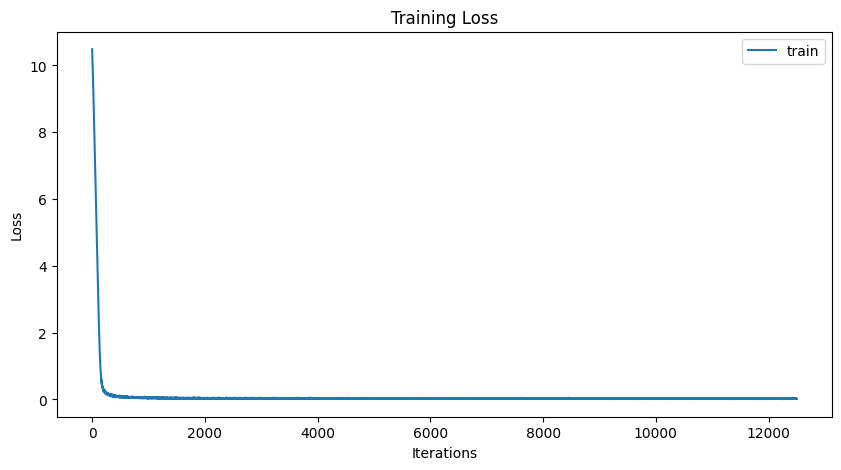

In [39]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(x_epoch,label="train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
#plt.plot(y_loss[x_epoch]) #Ignore this line, It's not valid.

TypeError: unhashable type: 'list'

In [ ]:
#If training fails due to GPU memory;
#torch.cuda.empty_cache()

In [ ]:
#after running the command above (in case of failure) flush the VRAM by closing and reopening visual studio code. (Or Google Colab)

In [ ]:
model.eval() #Turning on evaluation mode, As I am done training.

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr